In [58]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/air-quality-2024/Cairo_Air_Quality.csv
/kaggle/input/air-quality-2024/Air_Quality.csv
/kaggle/input/air-quality-2024/London_Air_Quality.csv
/kaggle/input/air-quality-2024/New_York_Air_Quality.csv
/kaggle/input/air-quality-2024/Dubai_Air_Quality.csv
/kaggle/input/air-quality-2024/Sydney_Air_Quality.csv
/kaggle/input/air-quality-2024/Brasilia_Air_Quality.csv


In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [60]:
# Load data and view basic column info and missing values
df = pd.read_csv('/kaggle/input/air-quality-2024/Air_Quality.csv')

print("\nFirst 5 entries:")
print(df.head())
print("\nColumn Info:")
print(df.info())
print("\nMissing Values in each Column:")
print(df.isnull().sum())


First 5 entries:
                        Date      City     CO  CO2   NO2  SO2    O3  PM2.5  \
0  2024-01-01 00:00:00+00:00  Brasilia  323.0  NaN  23.8  2.8  42.0   12.0   
1  2024-01-01 01:00:00+00:00  Brasilia  318.0  NaN  21.9  2.7  40.0   12.5   
2  2024-01-01 02:00:00+00:00  Brasilia  309.0  NaN  19.2  2.6  39.0   12.1   
3  2024-01-01 03:00:00+00:00  Brasilia  295.0  NaN  16.3  2.4  38.0   11.4   
4  2024-01-01 04:00:00+00:00  Brasilia  270.0  NaN  13.0  2.1  40.0   10.2   

   PM10        AQI  
0  17.1  16.800000  
1  17.9  16.000000  
2  17.3  15.599999  
3  16.2  15.200000  
4  14.6  16.000000  

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52704 entries, 0 to 52703
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    52704 non-null  object 
 1   City    52704 non-null  object 
 2   CO      52704 non-null  float64
 3   CO2     9648 non-null   float64
 4   NO2     52704 non-null  float64
 5   

In [61]:
# Summary statistics
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
                 CO          CO2           NO2           SO2            O3  \
count  52704.000000  9648.000000  52704.000000  52704.000000  52704.000000   
mean     258.258121   462.348259     24.102998     12.569869     60.025729   
std      159.589953    33.769009     19.363443     17.266623     38.217348   
min       52.000000   434.000000      0.000000      0.000000      0.000000   
25%      159.000000   445.000000      9.700000      2.300000     35.000000   
50%      213.000000   453.000000     18.900000      5.700000     54.000000   
75%      306.000000   467.000000     33.400000     16.800000     78.000000   
max     2045.000000   884.000000    165.900000    239.700000    349.000000   

              PM2.5          PM10           AQI  
count  52704.000000  52704.000000  52704.000000  
mean      17.689931     35.643143     41.349339  
std       15.670075     48.444774     26.626149  
min        0.100000      0.100000      4.450000  
25%        6.900000     10

**Note:** Too many missing values in CO2, so we will probably just drop it

## 1. Exploratory Data Analysis

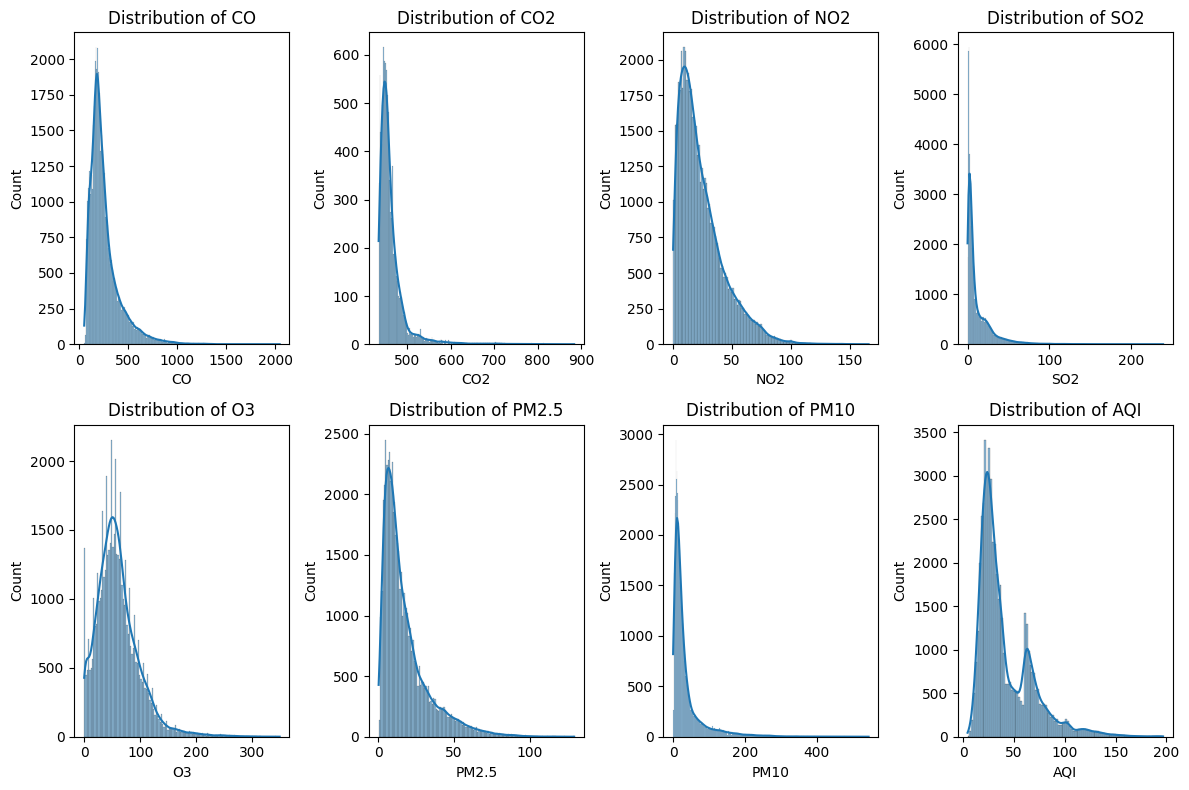

In [62]:
# Distribution of AQI and pollutants
plt.figure(figsize=(12, 8))
for i, col in enumerate(['CO', 'CO2', 'NO2', 'SO2', 'O3', 'PM2.5', 'PM10', 'AQI']):
    plt.subplot(2, 4, i+1)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

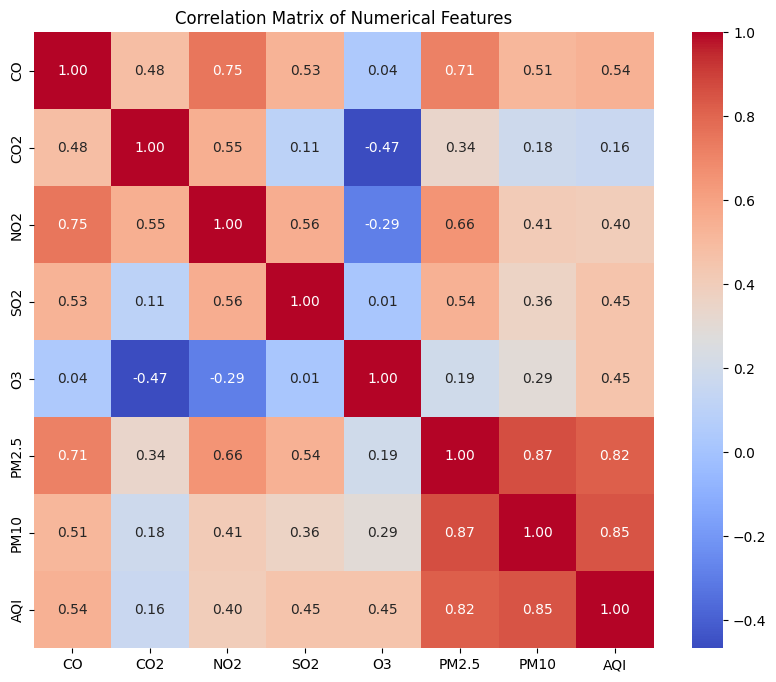

In [63]:
# Correlation matrix
plt.figure(figsize=(10, 8))
numeric_cols = ['CO', 'CO2', 'NO2', 'SO2', 'O3', 'PM2.5', 'PM10', 'AQI']
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

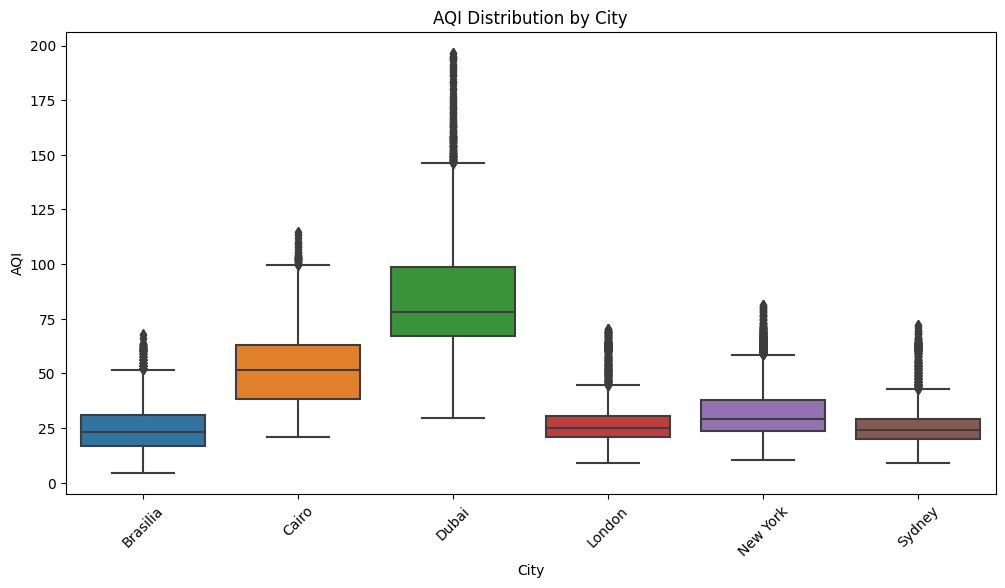

In [64]:
# AQI trends by city
plt.figure(figsize=(12, 6))
sns.boxplot(x='City', y='AQI', data=df)
plt.xticks(rotation=45)
plt.title('AQI Distribution by City')
plt.show()

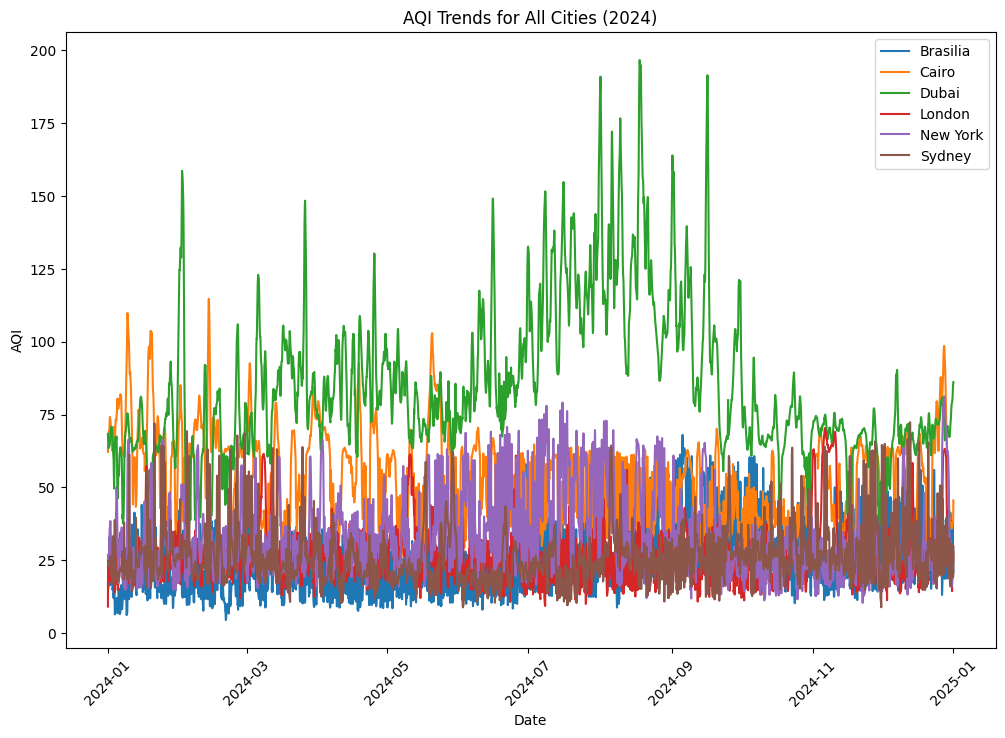

In [65]:
# 6. Temporal trends (AQI over time for all cities)
df['Date'] = pd.to_datetime(df['Date'])
plt.figure(figsize=(12, 8))
for city in df['City'].unique():
    city_df = df[df['City'] == city]
    plt.plot(city_df['Date'], city_df['AQI'], label=city)
plt.title('AQI Trends for All Cities (2024)')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.xticks(rotation=45)
plt.legend()
plt.show()

#### **Analysis of Results**

**1. Distribution of Features**

- **CO, NO2, SO2, O3, PM2.5, PM10, AQI:** Right-skewed with long tails, suggest potential need for log-transformation or robust scaling to handle outliers during preprocessing.
- **CO2:** More symmetric but has a much smaller sample size due to missing values, reinforces the need to decide whether to impute or drop this column.
- **AQI:** Right-skewed, which may impact regression model performance. We might consider transforming the target (e.g., log(AQI)) if we use a linear model.

**2. Correlation Matrix**

- **Strong Positive Correlations:**
    - **PM2.5 and PM10 (0.87):** High correlation, expected as both measure particulate matter, but this may introduce multicollinearity in linear models.
    - **PM2.5 and AQI (0.82), PM10 and AQI (0.85):** Particulate matter strongly influences AQI, makes these key features for prediction.
    - **CO and NO2 (0.75), CO and PM2.5 (0.71):** Pollutants from similar sources (e.g., traffic, industry) are correlated.
- **Negative Correlation:**
    - **CO2 and O3 (-0.47):** Interesting inverse relationship, possibly due to photochemical reactions where high CO2 levels might suppress ozone formation.
- **Weak Correlations:**
    - **SO2 with most variables (e.g., 0.01 with O3):** SO2 may not be a strong predictor of AQI on its own but could contribute in nonlinear models.
- **Note**: We’ll need to address multicollinearity (e.g., PM2.5 and PM10) for linear models, possibly by feature selection or dimensionality reduction (e.g., PCA).

**3. AQI Distribution by City (Boxplot)**

- **Brasilia:** Low AQI, few outliers, indicates consistently good air quality.
- **Cairo:** Higher AQI with outliers up to ~125, suggests more pollution and variability.
- **Dubai:** Highest AQI with extreme outliers up to 200, indicates severe pollution episodes.
- **London, New York, Sydney:** Lower AQIs, with some outliers, suggest generally better air quality but occasional spikes.
- **Implication:** City-specific differences are significant, so encoding the City variable (e.g., one-hot encoding) will be crucial for capturing these variations in the model.

**4. AQI Over Time for All Cities**

- All cities show fluctuating AQI levels throughout 2024, with noticeable peaks and troughs. This points to temporal patterns (e.g., seasonal or monthly trends).
- **Brasilia:** Stays consistently low, with minor fluctuations.
- **Cairo:** Shows periodic spikes, especially around mid-year, indicating seasonal pollution events.
- **Dubai:** Frequent high spikes, particularly in early and late 2024. This reflects severe pollution episodes.
- **London, New York, Sydney:** Generally lower AQI with occasional spikes, showing similar patterns but with less intensity than Cairo and Dubai.

## 2. Preprocessing and Feature Engineering

In [66]:
# Drop CO2 due to high missingness
df = df.drop(columns=['CO2'])

In [67]:
# Extract temporal features from Date
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Hour'] = df['Date'].dt.hour

In [68]:
# Create lag feature for AQI 
df = df.sort_values(by=['City', 'Date'])  
df['AQI_Lag1'] = df.groupby('City')['AQI'].shift(1)

In [69]:
# Create pollutant ratio to address multicollinearity
df['PM_Ratio'] = df['PM2.5'] / df['PM10']

In [70]:
# Drop rows with NaN values in lag features
df = df.dropna()

In [71]:
# Encode City
df = pd.get_dummies(df, columns=['City'], drop_first=True)

In [72]:
# Define features and target
X = df.drop(columns=['AQI', 'Date']) 
y = df['AQI']

In [73]:
# Split data into train and test sets 
train_size = int(0.8 * len(df))
X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

In [74]:
# Scale numerical features 
scaler = RobustScaler()
numerical_cols = ['CO', 'NO2', 'SO2', 'O3', 'PM2.5', 'PM10', 'AQI_Lag1', 'PM_Ratio']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

## 3. Model Selection and Training

In [75]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1)
}

In [76]:
# Set up TimeSeriesSplit for cross-validation 
tscv = TimeSeriesSplit(n_splits=5)

In [77]:
# Evaluate each model using cross-validation
cv_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    cv_scores[name] = scores
    print(f"{name} CV R² Scores: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

Linear Regression CV R² Scores: 0.4875 (+/- 1.9618)
Random Forest CV R² Scores: 0.9424 (+/- 0.1754)
XGBoost CV R² Scores: 0.9066 (+/- 0.2723)
LightGBM CV R² Scores: 0.8910 (+/- 0.3485)


#### **Analysis of Results**

- Random Forest stands out as the best model with the highest mean CV R² (0.9424) and reasonable stability. This aligns with its ability to handle the temporal and nonlinear nature of the data.
- The superior performance of tree-based models (Random Forest, XGBoost, LightGBM) over Linear Regression confirms the presence of nonlinear relationships and feature interactions. This validates the steps we took during feature engineering.
- The high R² values suggest the model captures most of the variance in AQI

## 4. Model Evaluation

In [78]:
# Train Random Forest on the full training set
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [79]:
# Predict on the test set
y_pred = rf_model.predict(X_test)

In [80]:
# Calculate evaluation metrics
test_r2 = r2_score(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mae = mean_absolute_error(y_test, y_pred)

print(f"Test Set R²: {test_r2:.4f}")
print(f"Test Set RMSE: {test_rmse:.4f}")
print(f"Test Set MAE: {test_mae:.4f}")

Test Set R²: 0.9807
Test Set RMSE: 1.3721
Test Set MAE: 0.7600


In [81]:
# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

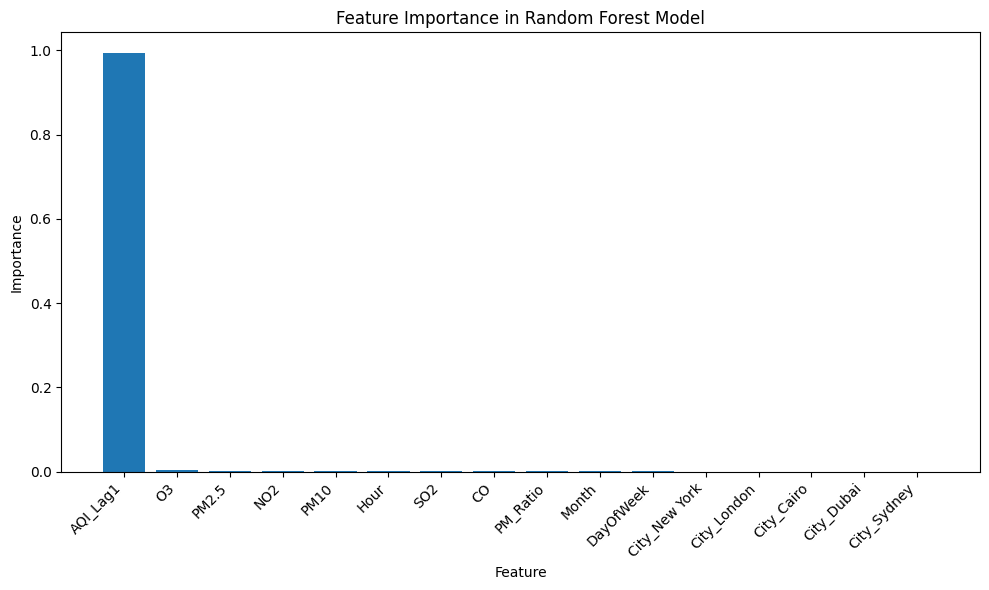

In [82]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

#### **Analysis of Results**

- The R² score of 0.9807 means that the Random Forest model explains 98.07% of the variance in the AQI values on the test set, an excellent result.
- Compared to the cross-validation R² score (0.9424 ± 0.1754), the test set performance is even better, which is a sign that the model is not overfitting.
- RMSE measures the average prediction error in the same units as AQI. Given that AQI in the dataset ranges from 4.45 to 196.63 (mean 41.35, std 26.63), an RMSE of 1.3721 is very low. This means that our model has very high accuracy.
- The MAE of 0.7600 indicates that, on average, the model’s predictions are off by less than 1 AQI unit. This further confirms the model’s ability to make accurate predictions with minimal deviation.
- The combination of a high R², low RMSE, and low MAE demonstrates that the Random Forest model is highly effective for AQI prediction.
- The lagged AQI value (previous hour’s AQI) is by far the most important feature, contributing approximately 90% to the model’s predictions. This aligns with the temporal nature of air quality data, where the AQI at a given hour is strongly influenced by the AQI in the previous hour due to the persistence of pollution levels.